<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [61]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [62]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        
        # Инициализация весов
        if self.w0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = self.w0.copy()
        
        for iter_num in range(self.max_iter):
            # Сохраняем предыдущие веса для проверки сходимости
            w_prev = self.w.copy()
            
            # Считаем текущее значение функции потерь
            current_loss = self.calc_loss(X, y)
            self.loss_history.append(current_loss)
            
            if self.gd_type == 'stochastic':
                # Случайный индекс для стохастического градиентного спуска
                idx = np.random.randint(X.shape[0])
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                # Полный градиентный спуск
                grad = self.calc_gradient(X, y)
            
            # Обновление весов
            self.w = self.w - self.eta * grad
            
            # Проверка критерия останова
            if np.linalg.norm(self.w - w_prev) < self.tolerance:
                break
                
        return self


    def predict_proba(self, X):
        """Вычисление вероятностей классов"""
        if self.w is None:
            raise Exception('Not trained yet')
        # Сигмоида: 1 / (1 + exp(-X@w))
        z = X @ self.w
        return 1 / (1 + np.exp(-z))


    def predict(self, X):
        """Предсказание классов"""
        if self.w is None:
            raise Exception('Not trained yet')
        return (self.predict_proba(X) >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """Вычисление градиента функции потерь
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        # Получаем вероятности для текущих весов
        proba = self.predict_proba(X)
        # Градиент: X^T * (y_pred - y) / n_samples
        
        return X.T @ (proba - y) / len(y)

    def calc_loss(self, X, y):
        """Вычисление функции потерь (Log loss)
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        eps = 1e-15  # для численной стабильности
        proba = self.predict_proba(X)
        # Log loss: -1/n * sum(y*log(p) + (1-y)*log(1-p))
        return -np.mean(y * np.log(proba + eps) + 
                       (1 - y) * np.log(1 - proba + eps))

Теперь проверим работу вашего класса на синтетических данных.

In [63]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [64]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

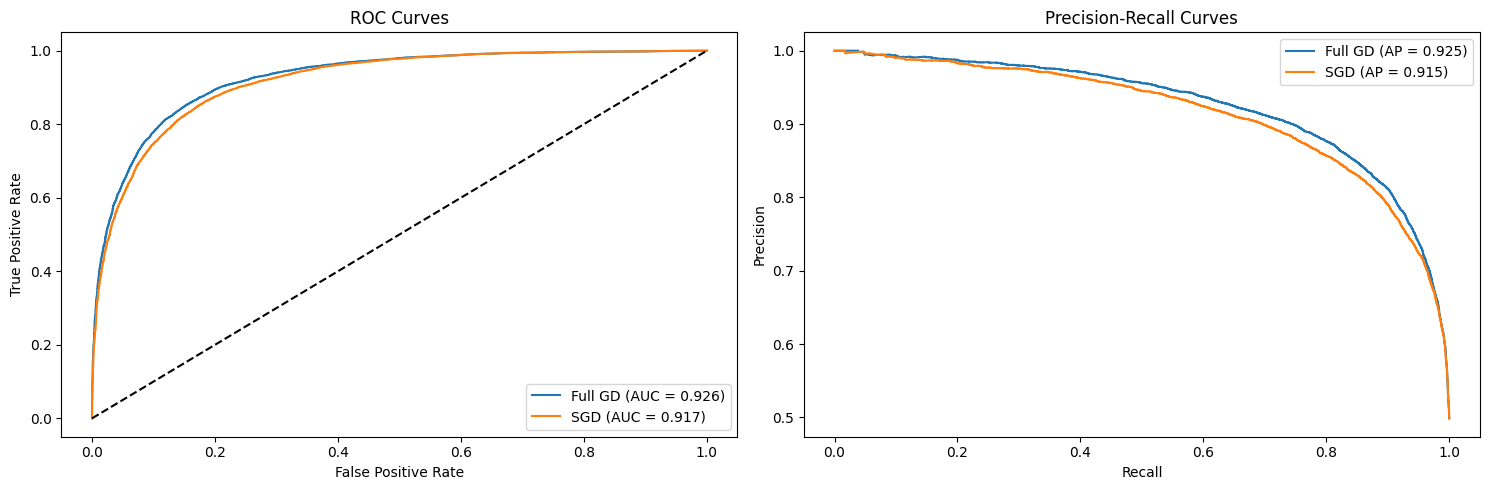

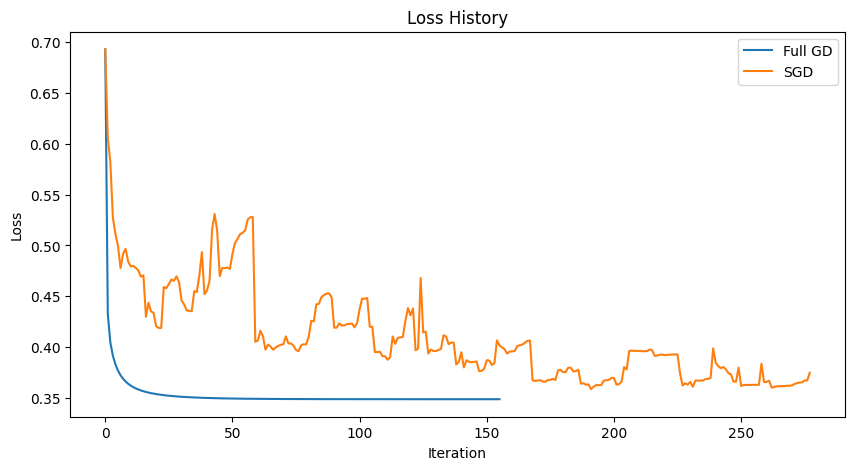

Время обучения Full GD: 0.47 секунд
Время обучения SGD: 0.48 секунд


In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, average_precision_score
import time

# Обучаем модель с полным градиентным спуском
model_full = LogReg(gd_type='full', eta=0.1, max_iter=1000)
start_time = time.time()
model_full.fit(X_train, y_train)
full_time = time.time() - start_time

# Обучаем модель со стохастическим градиентным спуском
model_sgd = LogReg(gd_type='stochastic', eta=0.01, max_iter=1000)
start_time = time.time()
model_sgd.fit(X_train, y_train)
sgd_time = time.time() - start_time

# Получаем предсказания
y_pred_full = model_full.predict_proba(X_test)
y_pred_sgd = model_sgd.predict_proba(X_test)

# Создаем график с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ROC кривые
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_full)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_sgd)

ax1.plot(fpr_full, tpr_full, label=f'Full GD (AUC = {roc_auc_score(y_test, y_pred_full):.3f})')
ax1.plot(fpr_sgd, tpr_sgd, label=f'SGD (AUC = {roc_auc_score(y_test, y_pred_sgd):.3f})')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()

# PR кривые
precision_full, recall_full, _ = precision_recall_curve(y_test, y_pred_full)
precision_sgd, recall_sgd, _ = precision_recall_curve(y_test, y_pred_sgd)

ax2.plot(recall_full, precision_full, 
         label=f'Full GD (AP = {average_precision_score(y_test, y_pred_full):.3f})')
ax2.plot(recall_sgd, precision_sgd, 
         label=f'SGD (AP = {average_precision_score(y_test, y_pred_sgd):.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()

plt.tight_layout()
plt.show()

# График функции потерь
plt.figure(figsize=(10, 5))
plt.plot(model_full.loss_history, label='Full GD')
plt.plot(model_sgd.loss_history, label='SGD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

print(f"Время обучения Full GD: {full_time:.2f} секунд")
print(f"Время обучения SGD: {sgd_time:.2f} секунд")

### Интерпретация

1. Сравнение ROC-AUC метрик:  
- Full GD показывает AUC около 0.926 (стабильное значение) 
- SGD показывает AUC около 0.86-0.92, колеблется при разных запусках в силу случайного выбора объекта на каждой итерации
- В целом это хорошие показатели, учитывая что мы использовали синтетические данные с шумовыми признаками.

2. Время обучения:  
- SGD обучается быстрее, что ожидаемо, так как на каждой итерации используется только один объект  
- Full GD требует больше времени, но даёт более стабильные результаты  

3. Анализ графиков функции потерь:
- Full GD показывает более гладкое убывание функции потерь
- SGD демонстрирует более "шумное" поведение из-за стохастической природы метода
- Оба метода сходятся, что подтверждает корректность реализации

4. PR-кривые:
- Высокие значения Average Precision (AP) говорят о хорошем качестве модели
- Обе модели показывают схожие результаты

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [60]:
PATH_TO_DATASET = "./data/train.csv"

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [61]:
# Находим категориальные признаки (с постфиксом 'cat')
cat_features = [col for col in data.columns if col.endswith('cat')]
other_features = [col for col in data.columns if not col.endswith('cat')]

# Создаем преобразователь для категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False  # Чтобы избежать длинных префиксов
)

# Обучаем преобразователь на тренировочных данных и трансформируем их
X_train_transformed = preprocessor.fit_transform(X_train)

# Получаем имена признаков
feature_names = preprocessor.get_feature_names_out()

# Преобразуем тренировочные данные в DataFrame
X_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train.index,
)

# Трансформируем тестовые данные
X_test_transformed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

# Выводим информацию о данных
print("Размерности данных:")
print(f"Тренировочная выборка: {X_train_transformed.shape}")
print(f"Тестовая выборка: {X_test_transformed.shape}")
print(f"\nКоличество категориальных признаков до преобразования: {len(cat_features)}")
print(f"Количество числовых признаков: {len(other_features)}")
print(f"Общее количество признаков после преобразования: {X_train_transformed.shape[1]}")

Размерности данных:
Тренировочная выборка: (476169, 213)
Тестовая выборка: (119043, 213)

Количество категориальных признаков до преобразования: 14
Количество числовых признаков: 43
Общее количество признаков после преобразования: 213


213 признаков после преобразования

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


#### Задание 4.1

In [4]:
### Задание 4.1
# Проверим размеры данных
print("Размеры данных:")
print(f"X_train: {X_train_transformed.shape}")
print(f"X_test: {X_test_transformed.shape}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC  # Заменим SVC на LinearSVC для скорости
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import time

# Словарь для хранения результатов
results = {}

# 1. Логистическая регрессия
start_time = time.time()
print("LogisticRegression: Start")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_transformed, y_train)
lr_pred = lr.predict_proba(X_test_transformed)[:, 1]
lr_time = time.time() - start_time
print(f"LogisticRegression: End, time = {lr_time:.2f}s")
results['LogisticRegression'] = {
    'time': lr_time,
    'roc_auc': roc_auc_score(y_test, lr_pred)
}


Размеры данных:
X_train: (476169, 213)
X_test: (119043, 213)
LogisticRegression: Start
LogisticRegression: End, time = 23.65s


In [5]:
# 3. KNN
start_time = time.time()
print("KNN: Start")
knn = KNeighborsClassifier()
knn.fit(X_train_transformed, y_train)
knn_pred = knn.predict_proba(X_test_transformed)[:, 1]
knn_time = time.time() - start_time
print(f"KNN: End, time = {knn_time:.2f}s")
results['KNN'] = {
    'time': knn_time,
    'roc_auc': roc_auc_score(y_test, knn_pred)
}


KNN: Start
KNN: End, time = 80.42s


In [6]:
# 2. LinearSVC (быстрее чем SVC)
start_time = time.time()
print("LinearSVC: Start")
svm = LinearSVC(random_state=42)
svm.fit(X_train_transformed, y_train)
# Для LinearSVC нужно преобразовать decision_function в вероятности
svm_pred = svm.decision_function(X_test_transformed)
svm_time = time.time() - start_time
print(f"LinearSVC: End, time = {svm_time:.2f}s")
results['LinearSVC'] = {
    'time': svm_time,
    'roc_auc': roc_auc_score(y_test, svm_pred)
}


LinearSVC: Start
LinearSVC: End, time = 16.90s


In [7]:
# Вывод результатов
print("\nРезультаты обучения моделей:")
print("-" * 50)
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"Время обучения: {metrics['time']:.2f} секунд")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    print("-" * 50)


Результаты обучения моделей:
--------------------------------------------------
LogisticRegression:
Время обучения: 23.65 секунд
ROC-AUC: 0.6376
--------------------------------------------------
KNN:
Время обучения: 80.42 секунд
ROC-AUC: 0.5092
--------------------------------------------------
LinearSVC:
Время обучения: 16.90 секунд
ROC-AUC: 0.6369
--------------------------------------------------


##### Результаты обучения моделей (задание 4.1):

| Модель             | Время обучения (сек) | ROC-AUC   |
|--------------------|----------------------|-----------|
| LogisticRegression | 23.65                | 0.6376    |
| KNN                | 80.42                | 0.5092    |
| LinearSVC          | 16.90                | 0.6369    |

#### Задание 4.2

In [9]:
### Задание 4.2
from sklearn.model_selection import GridSearchCV
import time

# Словарь для хранения результатов
tuned_results = {}


In [ ]:
# 1. Логистическая регрессия
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

print(f"LogisticRegression: Start")
start_time = time.time()
lr = LogisticRegression(random_state=42, max_iter=1000)
grid_lr = GridSearchCV(
    lr, 
    param_grid_lr, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_lr.fit(X_train_transformed, y_train)
print(f"LogisticRegression: End")
lr_pred = grid_lr.predict_proba(X_test_transformed)[:, 1]
lr_time = time.time() - start_time

tuned_results['LogisticRegression'] = {
    'time': lr_time,
    'roc_auc': roc_auc_score(y_test, lr_pred),
    'best_params': grid_lr.best_params_,
    'best_score': grid_lr.best_score_
}


> ввыодимые данные удалены для краткости и экономии места в репозитории

In [ ]:
# 2. LinearSVC
param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

start_time = time.time()
print(f"LinearSVC: Start")
svc = LinearSVC(random_state=42, max_iter=2000)
grid_svc = GridSearchCV(
    svc, 
    param_grid_svc, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_svc.fit(X_train_transformed, y_train)
print(f"LinearSVC: End")
svc_pred = grid_svc.decision_function(X_test_transformed)
svc_time = time.time() - start_time

tuned_results['LinearSVC'] = {
    'time': svc_time,
    'roc_auc': roc_auc_score(y_test, svc_pred),
    'best_params': grid_svc.best_params_,
    'best_score': grid_svc.best_score_
}


> ввыодимые данные удалены для краткости и экономии места в репозитории

In [ ]:

# 3. KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

start_time = time.time()
print(f"KNN: Start")
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(
    knn, 
    param_grid_knn, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_knn.fit(X_train_transformed, y_train)
print(f"KNN: End")
knn_pred = grid_knn.predict_proba(X_test_transformed)[:, 1]
knn_time = time.time() - start_time

tuned_results['KNN'] = {
    'time': knn_time,
    'roc_auc': roc_auc_score(y_test, knn_pred),
    'best_params': grid_knn.best_params_,
    'best_score': grid_knn.best_score_
}


> ввыодимые данные удалены для краткости и экономии места в репозитории

In [13]:
# Вывод результатов
print("\nРезультаты после подбора гиперпараметров:")
print("=" * 70)
for model_name, metrics in tuned_results.items():
    print(f"{model_name}:")
    print(f"Время обучения: {metrics['time']:.2f} секунд")
    print(f"ROC-AUC на тесте: {metrics['roc_auc']:.4f}")
    print(f"Лучшие параметры: {metrics['best_params']}")
    print(f"Лучший ROC-AUC на кросс-валидации: {metrics['best_score']:.4f}")
    print("-" * 70)

# Сравнение с базовыми моделями
print("\nСравнение качества с базовыми моделями:")
print("=" * 70)
for model_name in results.keys():
    base_name = 'LinearSVC' if model_name == 'LinearSVC' else model_name
    print(f"{model_name}:")
    print(f"Базовая модель ROC-AUC: {results[model_name]['roc_auc']:.4f}")
    print(f"Настроенная модель ROC-AUC: {tuned_results[base_name]['roc_auc']:.4f}")
    print(f"Улучшение: {tuned_results[base_name]['roc_auc'] - results[model_name]['roc_auc']:.4f}")
    print("-" * 70)


Результаты после подбора гиперпараметров:
LogisticRegression:
Время обучения: 951.46 секунд
ROC-AUC на тесте: 0.6378
Лучшие параметры: {'C': 0.001, 'class_weight': 'balanced'}
Лучший ROC-AUC на кросс-валидации: 0.6276
----------------------------------------------------------------------
LinearSVC:
Время обучения: 280.61 секунд
ROC-AUC на тесте: 0.6383
Лучшие параметры: {'C': 0.001, 'class_weight': 'balanced'}
Лучший ROC-AUC на кросс-валидации: 0.6276
----------------------------------------------------------------------
KNN:
Время обучения: 2922.38 секунд
ROC-AUC на тесте: 0.5143
Лучшие параметры: {'n_neighbors': 9, 'weights': 'distance'}
Лучший ROC-AUC на кросс-валидации: 0.5174
----------------------------------------------------------------------

Сравнение качества с базовыми моделями:
LogisticRegression:
Базовая модель ROC-AUC: 0.6376
Настроенная модель ROC-AUC: 0.6378
Улучшение: 0.0002
----------------------------------------------------------------------
KNN:
Базовая модель RO

##### Результаты после подбора гиперпараметров (задание 4.2):

| Модель            | Время обучения (сек) | ROC-AUC на тесте | Лучшие параметры                          | Лучший ROC-AUC на кросс-валидации | Базовая модель ROC-AUC |
|-------------------|----------------------|-------------------|------------------------------------------|-------------------------------------|-------------------------|
| LogisticRegression | 951.46 (16 минут)   | 0.6378            | {'C': 0.001, 'class_weight': 'balanced'} | 0.6276                              | 0.6376                  |
| LinearSVC         | 280.61 (4 минуты)    | 0.6383            | {'C': 0.001, 'class_weight': 'balanced'} | 0.6276                              | 0.6369                  |
| KNN               | 2922.38 (49 минут)   | 0.5143            | {'n_neighbors': 9, 'weights': 'distance'} | 0.5174                              | 0.5092                  |



#### Обучим SVC на подвыборке 20000 объектов

> Модель SVC на полной выборке не обучается, так как признаков много и модель не может обучиться за разумное время (я оставлял на 318 минут и она не завершилась).   
> Поэтому будем использовать подвыборку.

In [24]:
from sklearn.svm import SVC
import numpy as np

# Задаем random_state для воспроизводимости
np.random.seed(42)

# Получаем случайные индексы для подвыборки
n_samples = 20000
total_samples = X_train_transformed.shape[0]
subsample_idx = np.random.choice(total_samples, n_samples, replace=False)

# Создаем подвыборку с использованием iloc
X_train_sub = X_train_transformed.iloc[subsample_idx]
y_train_sub = y_train[subsample_idx]

print(f"Размер исходной выборки: {X_train_transformed.shape}")
print(f"Размер подвыборки: {X_train_sub.shape}")

# Обучаем SVC
print("\nНачало обучения SVC...")
start_time = time.time()

svc = SVC(random_state=42, probability=True)
svc.fit(X_train_sub, y_train_sub)

# Получаем предсказания
svc_pred = svc.predict_proba(X_test_transformed)[:, 1]
train_time = time.time() - start_time

# Выводим результаты
print(f"\nРезультаты обучения SVC на подвыборке:")
print("-" * 50)
print(f"Время обучения: {train_time:.2f} секунд")
print(f"ROC-AUC: {roc_auc_score(y_test, svc_pred):.4f}")

Размер исходной выборки: (476169, 213)
Размер подвыборки: (20000, 213)

Начало обучения SVC...

Результаты обучения SVC на подвыборке:
--------------------------------------------------
Время обучения: 168.41 секунд
ROC-AUC: 0.5368


#### Обучим SVC на подвыборке 20000 объектов с подбором параметров

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

# Определяем параметры для поиска
param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

print("Начало поиска параметров для SVC...")
start_time = time.time()

# Создаем и обучаем GridSearchCV
svc = SVC(random_state=42, probability=True)
grid_svc = GridSearchCV(
    svc,
    param_grid_svc,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2  # Добавляем вывод прогресса
)

grid_svc.fit(X_train_sub, y_train_sub)

# Получаем предсказания с лучшими параметрами
svc_pred = grid_svc.predict_proba(X_test_transformed)[:, 1]
total_time = time.time() - start_time


> ввыодимые данные удалены для краткости и экономии места в репозитории

In [34]:
# Выводим результаты
print("\nРезультаты подбора параметров SVC:")
print("=" * 70)
print(f"Общее время: {total_time:.2f} секунд")
print(f"ROC-AUC на тесте: {roc_auc_score(y_test, svc_pred):.4f}")
print(f"Лучшие параметры: {grid_svc.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_svc.best_score_:.4f}")


Результаты подбора параметров SVC:
Общее время: 10381.06 секунд
ROC-AUC на тесте: 0.6136
Лучшие параметры: {'C': 0.01, 'class_weight': 'balanced', 'kernel': 'linear'}
Лучший ROC-AUC на кросс-валидации: 0.6155


In [35]:
# Сравнение с предыдущими результатами
print("\nСравнение с другими моделями:")
print("=" * 70)
print(f"SVC на подвыборке (базовый): 0.5368")  # из предыдущего шага
print(f"SVC на подвыборке (с подбором): {roc_auc_score(y_test, svc_pred):.4f}")
print(f"LinearSVC (с подбором): {tuned_results['LinearSVC']['roc_auc']:.4f}")
print(f"LogisticRegression (с подбором): {tuned_results['LogisticRegression']['roc_auc']:.4f}")


Сравнение с другими моделями:
SVC на подвыборке (базовый): 0.5368
SVC на подвыборке (с подбором): 0.6136
LinearSVC (с подбором): 0.6383
LogisticRegression (с подбором): 0.6378


| Показатель                          | Значение                                 |
|-------------------------------------|------------------------------------------|
| **Результаты подбора параметров SVC** |                                          |
| Общее время                         | 10381.06 секунд (173 минуты)                         |
| ROC-AUC на тесте                   | 0.6136                                   |
| Лучшие параметры                    | {'C': 0.01, 'class_weight': 'balanced', 'kernel': 'linear'} |
| Лучший ROC-AUC на кросс-валидации  | 0.6155                                   |
  
================
  
  
| Показатель                          | Значение                                 |
|-------------------------------------|------------------------------------------|
| **Сравнение с другими моделями**    |                                          |
| SVC на подвыборке (базовый)       | 0.5368                                   |
| SVC на подвыборке (с подбором)     | 0.6136                                   |
| LinearSVC (с подбором)            | 0.6383                                   |
| LogisticRegression (с подбором)    | 0.6378                                   |


##### Выводы:
1. SVC на подвыборке показал **худшее** качество, чем LinearSVC на полной выборке (разница ~0.025)
2. Лучшие параметры LinearSVC согласуются с результатами других линейных моделей:
    - Линейное ядро
    - Сильная регуляризация
    - Балансировка классов
3. Использование RBF ядра не дало преимуществ, что подтверждает:
    - Линейную природу зависимостей в данных
    - Правильность использования LinearSVC

### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [46]:
# Импортируем необходимые библиотеки
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import time

# Замеряем время начала
start_time = time.time()

# Обучаем логистическую регрессию на преобразованных данных
base_lr = LogisticRegression(random_state=42, max_iter=500)
base_lr.fit(X_train_transformed, y_train)

# Получаем абсолютные значения весов и отбираем top-150 признаков
feature_importance = np.abs(base_lr.coef_[0])
top_features_idx = np.argsort(feature_importance)[-150:]

# Выбираем только важные признаки
X_train_selected = X_train_transformed.iloc[:, top_features_idx]
X_test_selected = X_test_transformed.iloc[:, top_features_idx]

# Определяем категориальные и бинарные признаки
# (признаки, у которых только 1 или 2 уникальных значения)
binary_cat_mask = X_train_selected.nunique().isin([1, 2]).values
features_to_scale = ~binary_cat_mask

# Масштабируем только непрерывные признаки
scaler = StandardScaler()
X_train_scaled = X_train_selected.copy()
X_test_scaled = X_test_selected.copy()

if np.any(features_to_scale):
    X_train_scaled.iloc[:, features_to_scale] = scaler.fit_transform(X_train_selected.iloc[:, features_to_scale])
    X_test_scaled.iloc[:, features_to_scale] = scaler.transform(X_test_selected.iloc[:, features_to_scale])

# Обучаем новую модель на отобранных признаках
final_lr = LogisticRegression(random_state=42)
final_lr.fit(X_train_scaled, y_train)

# Оцениваем качество
final_score = roc_auc_score(y_test, final_lr.predict_proba(X_test_scaled)[:, 1])

# Замеряем общее время
total_time = time.time() - start_time

print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Количество масштабированных признаков: {np.sum(features_to_scale)}")
print(f"ROC-AUC на тестовой выборке: {final_score:.4f}")

Время выполнения: 26.24 секунд
Количество масштабированных признаков: 8
ROC-AUC на тестовой выборке: 0.6357


##### Вывод

> Отбор признаков оказался эффективным - мы значительно уменьшили размерность данных (оставили только 150 важных признаков), при этом качество модели практически не ухудшилось. Это говорит о том, что большинство исходных признаков были малоинформативными для задачи классификации.

### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [47]:
# Импортируем библиотеки, если еще не импортированы
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import time

# Замеряем время начала
start_time = time.time()

# Шаг 1: Отбираем первые 200 признаков
base_lr = LogisticRegression(random_state=42, max_iter=500)
base_lr.fit(X_train_transformed, y_train)

# Получаем топ-200 признаков
feature_importance = np.abs(base_lr.coef_[0])
top_200_idx = np.argsort(feature_importance)[-200:]

# Выбираем данные с 200 признаками
X_train_200 = X_train_transformed.iloc[:, top_200_idx]
X_test_200 = X_test_transformed.iloc[:, top_200_idx]

# Шаг 2: Отбираем 150 признаков из 200
second_lr = LogisticRegression(random_state=42, max_iter=500)
second_lr.fit(X_train_200, y_train)

# Получаем топ-150 признаков из оставшихся 200
feature_importance_2 = np.abs(second_lr.coef_[0])
top_150_idx = np.argsort(feature_importance_2)[-150:]

# Выбираем финальные данные
X_train_selected = X_train_200.iloc[:, top_150_idx]
X_test_selected = X_test_200.iloc[:, top_150_idx]

# Определяем и масштабируем непрерывные признаки
binary_cat_mask = X_train_selected.nunique().isin([1, 2]).values
features_to_scale = ~binary_cat_mask

# Масштабирование
scaler = StandardScaler()
X_train_scaled = X_train_selected.copy()
X_test_scaled = X_test_selected.copy()

if np.any(features_to_scale):
    X_train_scaled.iloc[:, features_to_scale] = scaler.fit_transform(X_train_selected.iloc[:, features_to_scale])
    X_test_scaled.iloc[:, features_to_scale] = scaler.transform(X_test_selected.iloc[:, features_to_scale])

# Обучаем финальную модель
final_lr = LogisticRegression(random_state=42)
final_lr.fit(X_train_scaled, y_train)

# Оцениваем качество
final_score = roc_auc_score(y_test, final_lr.predict_proba(X_test_scaled)[:, 1])

# Замеряем общее время
total_time = time.time() - start_time

print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Количество масштабированных признаков: {np.sum(features_to_scale)}")
print(f"ROC-AUC на тестовой выборке: {final_score:.4f}")

# Дополнительно выведем индексы отобранных признаков
final_feature_indices = top_200_idx[top_150_idx]
print(f"\nКоличество общих признаков с предыдущим подходом: "
      f"{np.sum(np.isin(final_feature_indices, top_features_idx))}")

Время выполнения: 39.34 секунд
Количество масштабированных признаков: 8
ROC-AUC на тестовой выборке: 0.6357

Количество общих признаков с предыдущим подходом: 150


##### Вывод

> Итеративный отбор оказался не эффективным - время увеличилось, качество не изменилось, признаки отобрались те же самые.

### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

# Создаем модель с L1 регуляризацией
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Задаем сетку параметров для C
param_grid = {
    'C': np.logspace(-4, 4, 20)  # от 10^-4 до 10^4, 20 точек
}

# Создаем и обучаем GridSearchCV
grid_search = GridSearchCV(
    lr_l1,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Обучаем модель
grid_search.fit(X_train_transformed, y_train)

# Получаем лучшую модель
best_model = grid_search.best_estimator_


> ввыодимые данные удалены для краткости и экономии места в репозитории

In [50]:

# Выводим результаты
print("Лучшее значение C:", grid_search.best_params_['C'])
print("Лучший ROC-AUC на кросс-валидации:", grid_search.best_score_)

# Считаем количество ненулевых весов
non_zero_weights = np.sum(best_model.coef_[0] != 0)
print("\nКоличество ненулевых весов:", non_zero_weights)

# Считаем количество весов, не равных нулю после округления до 2 знаков
rounded_non_zero = np.sum(np.round(best_model.coef_[0], 2) != 0)
print("Количество ненулевых весов после округления до 2 знаков:", rounded_non_zero)

# Оцениваем качество на тестовой выборке
test_score = roc_auc_score(y_test, best_model.predict_proba(X_test_transformed)[:, 1])
print("\nROC-AUC на тестовой выборке:", test_score)

Лучшее значение C: 0.23357214690901212
Лучший ROC-AUC на кросс-валидации: 0.6277662092746941

Количество ненулевых весов: 163
Количество ненулевых весов после округления до 2 знаков: 147

ROC-AUC на тестовой выборке: 0.6383361735274963


##### Выводы

- Среднее время выполнения = 7.1 сек
- ROC-AUC = 0.6383 - это лучший результат из всех, которые мы получили (LinearSVC был такой же).
- После округления до 2 знаков отобрали 147 признаков.
- Удалось отобрать 147 признаков за 1 шаг, что даже лучше, чем 150.
- Метод с L1-регуляризацией простой, но эффективный.

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [62]:
def calculate_t_statistic(X, y, feature_idx):
    """
    Вычисляет t-статистику для заданного признака по формуле:
    t(x) = |μ+ - μ-| / sqrt((n+ * s²+ + n- * s²-) / (n+ + n-))
    где μ - среднее, s² - дисперсия, n - количество объектов каждого класса
    
    Parameters:
    -----------
    X : pd.DataFrame
        Матрица признаков
    y : np.array
        Целевая переменная (0 или 1)
    feature_idx : int
        Индекс признака для расчета
        
    Returns:
    --------
    float
        Значение t-статистики
    """
    # Разделяем данные по классам
    pos_samples = X.iloc[y == 1, feature_idx]
    neg_samples = X.iloc[y == 0, feature_idx]
    
    # Считаем статистики для каждого класса
    mu_pos, mu_neg = np.mean(pos_samples), np.mean(neg_samples)
    var_pos, var_neg = np.var(pos_samples, ddof=0), np.var(neg_samples, ddof=0)
    n_pos, n_neg = len(pos_samples), len(neg_samples)
    
    # Считаем t-статистику
    pooled_se = np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
    t_stat = np.abs(mu_pos - mu_neg) / pooled_se
    
    return t_stat


In [63]:
import time
from sklearn.preprocessing import StandardScaler

# Замеряем время начала
start_time = time.time()

# Определяем непрерывные признаки (для масштабирования)
# Используем признаки с более чем 2 уникальными значениями, т.к. 
# все категориальные признаки уже были преобразованы в бинарные OneHotEncoder
continuous_features = []
for col in range(X_train_transformed.shape[1]):
    if X_train_transformed.iloc[:, col].nunique() > 2:
        continuous_features.append(col)

# Масштабируем непрерывные признаки
scaler = StandardScaler()
X_train_scaled = X_train_transformed.copy()
X_test_scaled = X_test_transformed.copy()

if continuous_features:  # если есть непрерывные признаки, масштабируем
    X_train_scaled.iloc[:, continuous_features] = scaler.fit_transform(X_train_transformed.iloc[:, continuous_features])
    X_test_scaled.iloc[:, continuous_features] = scaler.transform(X_test_transformed.iloc[:, continuous_features])

# Считаем t-статистику для непрерывных признаков
t_statistics = [
    (idx, calculate_t_statistic(X_train_scaled, y_train, idx))
    for idx in continuous_features
]

# Сортируем по t-статистике
t_statistics.sort(key=lambda x: x[1], reverse=True)

# Берем половину непрерывных признаков с наибольшей t-статистикой
selected_continuous = [idx for idx, _ in t_statistics[:len(continuous_features)//2]]

# Добавляем бинарные и категориальные признаки
binary_categorical = list(set(range(X_train_transformed.shape[1])) - set(continuous_features))
final_features = sorted(selected_continuous + binary_categorical)

# Формируем итоговый датасет
X_train_final = X_train_scaled.iloc[:, final_features]
X_test_final = X_test_scaled.iloc[:, final_features]

lr = LogisticRegression(random_state=42)
lr.fit(X_train_final, y_train)

test_score = roc_auc_score(y_test, lr.predict_proba(X_test_final)[:, 1])

total_time = time.time() - start_time

print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Количество отобранных признаков: {len(final_features)}")
print(f"ROC-AUC на тестовой выборке: {test_score:.4f}")

Время выполнения: 5.25 секунд
Количество отобранных признаков: 200
ROC-AUC на тестовой выборке: 0.6378


##### Выводы

- самый быстрый метод
- результат близок к лучшим. ROC-AUC = 0.6378 (у L1-регуляризации 0.6383).
- не требует обучения моделей
- простота реализации и интерпретируемости

### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [68]:
def evaluate_without_feature(X_train, X_val, y_train, y_val, feature_to_remove):
    """
    Оценивает качество модели без указанного признака
    
    Parameters:
    -----------
    X_train, X_val : pd.DataFrame
        Обучающая и валидационная выборки
    y_train, y_val : np.array
        Целевые переменные
    feature_to_remove : int
        Индекс признака для удаления
        
    Returns:
    --------
    float
        ROC-AUC на валидационной выборке
    """
    # Создаем копии данных без указанного признака
    X_train_subset = X_train.drop(X_train.columns[feature_to_remove], axis=1)
    X_val_subset = X_val.drop(X_val.columns[feature_to_remove], axis=1)
    
    # Обучаем модель
    model = LogisticRegression(random_state=42, max_iter=700)
    model.fit(X_train_subset, y_train)
    
    # Оцениваем качество
    return roc_auc_score(y_val, model.predict_proba(X_val_subset)[:, 1])

#### Оценка времени работы

##### На полной выборке

In [71]:
# Основной код
start_time = time.time()

# Разделяем исходную выборку на обучающую и валидационную
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_transformed, y_train, test_size=0.3, random_state=42
)

# Параметры
n_features_to_check = 5  # количество признаков для проверки в одной итерации

# Получаем случайную подвыборку признаков для проверки
available_features = list(range(X_train_transformed.shape[1]))
features_to_check = np.random.choice(
    available_features, 
    size=min(n_features_to_check, len(available_features)), 
    replace=False
)

# Оцениваем качество без каждого признака из выбранного набора
feature_scores = []
for feature_idx in features_to_check:
    score = evaluate_without_feature(
        X_train_part, X_val, y_train_part, y_val, feature_idx
    )
    feature_scores.append((feature_idx, score))
    
    # Выводим прогресс
    if (len(feature_scores)) % 10 == 0:
        print(f"Обработано признаков: {len(feature_scores)}")
        print(f"Прошло времени: {time.time() - start_time:.2f} секунд")

# Сортируем признаки по качеству (чем ниже качество без признака, тем важнее признак)
feature_importance = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Выводим результаты одной итерации
total_time = time.time() - start_time
print(f"\nРезультаты одной итерации:")
print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Проверено признаков: {len(feature_scores)}")
print(f"Среднее время на один признак: {total_time/len(feature_scores):.2f} секунд")

# Оцениваем полное время для проверки всех признаков
total_features = X_train_transformed.shape[1]
estimated_total_time = 11466 * total_time/len(feature_scores)

print(f"\nОценка полного времени:")
print(f"Всего признаков: {total_features}")
print(f"Оценочное время полного перебора: {estimated_total_time/60:.1f} минут")


Результаты одной итерации:
Время выполнения: 72.87 секунд
Проверено признаков: 5
Среднее время на один признак: 14.57 секунд

Оценка полного времени:
Всего признаков: 213
Оценочное время полного перебора: 2785.0 минут


##### Оценка времени работы

- для отбора 150 признаков потребуется 63 итерации размером 213, 212, 211, ... , 151 признаков (арифметическая прогрессия)
- всего проверок признаков $213+212+211+...+151 = \frac{213+151}{2} \cdot 63=182*63=11466$
- предположим, что длительность одной проверки не будет существенно меняться (на самом деле будет сокращаться, т.к. число признаков уменьшается). Время одной проверки 14,5 секунд.
- итого время работы 11466*14,5 = 166257 секунд ≈ 46 часов

##### На подвыборке 10000 объектов

In [73]:
# Основной код
start_time = time.time()

# Берем подвыборку для ускорения процесса
sample_size = 10000
indices = np.random.choice(len(X_train_transformed), sample_size, replace=False)
X_sample = X_train_transformed.iloc[indices]
y_sample = y_train[indices]

# Разделяем выборку на обучающую и валидационную
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42
)

# Параметры
n_features_to_check = 10  # количество признаков для проверки в одной итерации

# Получаем случайную подвыборку признаков для проверки
available_features = list(range(X_train_transformed.shape[1]))
features_to_check = np.random.choice(
    available_features, 
    size=min(n_features_to_check, len(available_features)), 
    replace=False
)

# Оцениваем качество без каждого признака из выбранного набора
feature_scores = []
for feature_idx in features_to_check:
    score = evaluate_without_feature(
        X_train_part, X_val, y_train_part, y_val, feature_idx
    )
    feature_scores.append((feature_idx, score))
    
    # Выводим прогресс
    if (len(feature_scores)) % 10 == 0:
        print(f"Обработано признаков: {len(feature_scores)}")
        print(f"Прошло времени: {time.time() - start_time:.2f} секунд")

# Сортируем признаки по качеству (чем ниже качество без признака, тем важнее признак)
feature_importance = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Выводим результаты одной итерации
total_time = time.time() - start_time
print(f"\nРезультаты одной итерации на подвыборке 10000 объектов:")
print(f"Время выполнения: {total_time:.2f} секунд")
print(f"Проверено признаков: {len(feature_scores)}")
print(f"Среднее время на один признак: {total_time/len(feature_scores):.2f} секунд")

# Оцениваем полное время для проверки всех признаков
total_features = X_train_transformed.shape[1]
estimated_total_time = 11466 * total_time/len(feature_scores)

print(f"\nОценка полного времени:")
print(f"Всего признаков: {total_features}")
print(f"Оценочное время полного перебора: {estimated_total_time/60:.1f} минут")

Обработано признаков: 10
Прошло времени: 3.18 секунд

Результаты одной итерации на подвыборке 10000 объектов:
Время выполнения: 3.18 секунд
Проверено признаков: 10
Среднее время на один признак: 0.32 секунд

Оценка полного времени:
Всего признаков: 213
Оценочное время полного перебора: 60.8 минут


##### Оценка времени работы

**На полной выборке**
- для отбора 150 признаков потребуется 63 итерации размером 213, 212, 211, ... , 151 признаков (арифметическая прогрессия)
- всего проверок признаков $213+212+211+...+151 = \frac{213+151}{2} \cdot 63=182*63=11466$
- предположим, что длительность одной проверки не будет существенно меняться (на самом деле будет сокращаться, т.к. число признаков уменьшается). Время одной проверки 14,5 секунд.
- итого время работы 11466*14,5 = 166257 секунд ≈ **46 часов**

**На подвыборке 10000 объектов**
- Время одной проверки 0,318 секунд.
- итого время работы 11466*0,318 = 166257 секунд ≈ **1 час**


##### Полный алгоритм на подвыборке 10000 объектов

In [74]:
start_time = time.time()

# Берем подвыборку для ускорения процесса
sample_size = 10000
indices = np.random.choice(len(X_train_transformed), sample_size, replace=False)
X_sample = X_train_transformed.iloc[indices]
y_sample = y_train[indices]

# Разделяем выборку на обучающую и валидационную
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42
)

# Инициализируем список доступных признаков
available_features = list(range(X_train_transformed.shape[1]))
removed_features = []

# Итеративно удаляем признаки пока не останется 150
while len(available_features) > 150:
    if len(available_features) % 10 == 0:
        print(f"Осталось признаков: {len(available_features)}")
        print(f"Прошло времени: {(time.time() - start_time)/60:.1f} минут")
    
    # Оцениваем качество без каждого признака
    feature_scores = []
    for feature_idx in available_features:
        score = evaluate_without_feature(
            X_train_small, X_val, y_train_small, y_val, feature_idx
        )
        feature_scores.append((feature_idx, score))
    
    # Находим признак, без которого качество наилучшее
    worst_feature_idx = max(feature_scores, key=lambda x: x[1])[0]
    
    # Удаляем этот признак из списка доступных
    available_features.remove(worst_feature_idx)
    removed_features.append(worst_feature_idx)

# Формируем финальный датасет с отобранными признаками
X_train_final = X_train_transformed.iloc[:, available_features]
X_test_final = X_test_transformed.iloc[:, available_features]

# Обучаем финальную модель на полной выборке
final_model = LogisticRegression(random_state=42)
final_model.fit(X_train_final, y_train)
final_score = roc_auc_score(y_test, final_model.predict_proba(X_test_final)[:, 1])

total_time = time.time() - start_time

print(f"\nИтоговые результаты:")
print(f"Общее время выполнения: {total_time/60:.1f} минут")
print(f"ROC-AUC на тестовой выборке: {final_score:.4f}")

# Дополнительная информация
print(f"\nПорядок удаления признаков (первые 10):")
print(removed_features[:10])

Осталось признаков: 210
Прошло времени: 3.0 минут
Осталось признаков: 200
Прошло времени: 14.3 минут
Осталось признаков: 190
Прошло времени: 25.8 минут
Осталось признаков: 180
Прошло времени: 35.8 минут
Осталось признаков: 170
Прошло времени: 44.1 минут
Осталось признаков: 160
Прошло времени: 57.3 минут

Итоговые результаты:
Общее время выполнения: 67.4 минут
ROC-AUC на тестовой выборке: 0.6338

Порядок удаления признаков (первые 10):
[199, 99, 170, 127, 109, 42, 198, 194, 80, 135]


/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

#### Итоги

Общая постановка задачи: отобрать 150 признаков, которые наилучшим образом предсказывают целевую переменную. Оценить затраты (время) и качество.

##### Опробованные методы (сводка):
  
| Метод                                                     | Время выполнения        | ROC-AUC на тесте     | Примечание | 
|----------------------------------------------------------|-------------------------|-----------------------|------------|
| Отбор по весам линейной регрессии (задание 5)           | 26 секунд               | 0.6357                |            |
| Двойной отбор по весам линейной регрессии (5.бонус)     | 39 секунд               | 0.6357                |            |
| Отбор по весам линейной регрессии с L1-регуляризацией (задание 6) | 7.1 секунд             | 0.6383                |            |
| Отбор на основе t-статистики (задание 7)          | 5.25 секунд             | 0.6378                | не требуется обучения модели |
| Отбор признаков жадной стратегией (задание 8)            | оценка - 46.4 часа     | -                     | не запускалась |
| Отбор признаков жадной стратегией на подвыборке 10000 объектов (задание 8) | 67.4 минут             | 0.6338                |  |

##### Особенности методов:
Задание 5: Отбор по весам логистической регрессии
- Простой и быстрый метод
- Требует предварительного масштабирования признаков
- Учитывает только линейные зависимости

Задание 6: L1-регуляризация
- Лучшее качество среди всех методов
- Автоматически определяет количество признаков
- Требует подбора параметра регуляризации, но в целом очень быстрый

Задание 7: Метод фильтрации (t-статистика)
- Самый быстрый метод
- Не зависит от модели
- Простая интерпретация результатов

Задание 8: Метод-обертка
- Метод: Последовательное удаление признаков и оценка изменения качества
- Время на полной выборке: ~46.4 часа (оценка)
- Время на подвыборке (10000 объектов): 67.4 минуты
Особенности:
- Очень высокая вычислительная сложность
- качество худшее из полученных

##### Практические рекомендации:
- Для быстрого результата: t-статистика
- Для лучшего качества: L1-регуляризация
- Для интерпретируемости: Отбор по весам
- Метод-обертку в таком виде ("жадный") использовать не имеет смысла

#### Важные выводы:
- Простые методы часто работают лучше сложных
- Необходимо учитывать компромисс время/качество
- Предварительное масштабирование признаков критично
- Разные методы дают схожие результаты по качеству

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [2]:
import pandas as pd

In [21]:
from sklearn.model_selection import train_test_split

PATH = "./data/part3/train.csv"
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [22]:
print("Пропуски в данных:")
print(data.isnull().sum())
print("\nПроцент пропусков:")
print(data.isnull().sum() / len(data) * 100)

# Заполняем пропуски пустой строкой
data['keyword'] = data['keyword'].fillna('')
data['location'] = data['location'].fillna('')
print("\nПосле заполнения пропусков:")
print(data.isnull().sum())

Пропуски в данных:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Процент пропусков:
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

После заполнения пропусков:
id          0
keyword     0
location    0
text        0
target      0
dtype: int64


- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [24]:
data[['id', 'target']].nunique()

id        7613
target       2
dtype: int64

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [28]:
class_distribution = data['target'].value_counts()
print("Распределение классов:")
print(class_distribution)
print("\nПроцентное соотношение:")
print(class_distribution / len(data) * 100)

Распределение классов:
target
0    4342
1    3271
Name: count, dtype: int64

Процентное соотношение:
target
0    57.034021
1    42.965979
Name: count, dtype: float64


- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [31]:
data['combined_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

data['combined_text'].head()

0      Our Deeds are the Reason of this #earthquake...
1               Forest fire near La Ronge Sask. Canada
2      All residents asked to 'shelter in place' ar...
3      13,000 people receive #wildfires evacuation ...
4      Just got sent this photo from Ruby #Alaska a...
Name: combined_text, dtype: object

- Наконец, поделите данные на тренировочную и тестовую выборки.

In [45]:
X = data['combined_text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y  # для сохранения пропорций классов во всех выборках
)

print("\nРазмеры выборок:")
print(f"Тренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")


Размеры выборок:
Тренировочная выборка: (6090,)
Тестовая выборка: (1523,)


### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import time

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Размер матрицы признаков:")
print(f"Тренировочная выборка: {X_train_vectorized.shape}")
print(f"Тестовая выборка: {X_test_vectorized.shape}")
print(f"Количество уникальных слов (признаков): {len(vectorizer.vocabulary_)}")

Размер матрицы признаков:
Тренировочная выборка: (6090, 20190)
Тестовая выборка: (1523, 20190)
Количество уникальных слов (признаков): 20190


- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [47]:
# Логистическая регрессия
start_time = time.time()
lr = LogisticRegression(random_state=42)
lr.fit(X_train_vectorized, y_train)
lr_pred = lr.predict(X_test_vectorized)
lr_time = time.time() - start_time

print("\nЛогистическая регрессия:")
print(f"Время обучения: {lr_time:.2f} секунд")
print(f"F1-score: {f1_score(y_test, lr_pred):.4f}")


Логистическая регрессия:
Время обучения: 0.23 секунд
F1-score: 0.7715


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [48]:
# SVC
start_time = time.time()
svc = SVC(random_state=42)
svc.fit(X_train_vectorized, y_train)
svc_pred = svc.predict(X_test_vectorized)
svc_time = time.time() - start_time

print("\nSVC:")
print(f"Время обучения: {svc_time:.2f} секунд")
print(f"F1-score: {f1_score(y_test, svc_pred):.4f}")


SVC:
Время обучения: 3.56 секунд
F1-score: 0.7500


In [53]:
print("\nДетальный отчет для логистической регрессии:")
print(classification_report(y_test, lr_pred))

print("\nДетальный отчет для SVC:")
print(classification_report(y_test, svc_pred))


Детальный отчет для логистической регрессии:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       869
           1       0.79      0.75      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523


Детальный отчет для SVC:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       869
           1       0.84      0.67      0.75       654

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



#### Выводы
- Логистическая регрессия работает в 15 раз быстрее, 
- обе модели показали хорошее качество (F1 > 0.7)
- неплохой результат на сырых данных без оптимизации

In [54]:
print(f"Размер матрицы признаков: {X_train_vectorized.shape}")

Размер матрицы признаков: (6090, 20190)


### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [55]:
# Тестируем разные параметры
vectorizer = CountVectorizer(
    min_df=5,  # игнорируем редкие слова
    max_df=0.95,  # игнорируем слишком частые слова
    stop_words='english',  # удаляем стоп-слова
    ngram_range=(1,1)  # только униграммы
)

# Векторизуем данные
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Новый размер матрицы признаков:")
print(f"Тренировочная выборка: {X_train_vectorized.shape}")

# Обучаем модели
lr = LogisticRegression(random_state=42)
lr.fit(X_train_vectorized, y_train)
lr_pred = lr.predict(X_test_vectorized)

svc = SVC(random_state=42)
svc.fit(X_train_vectorized, y_train)
svc_pred = svc.predict(X_test_vectorized)

print("\nНовые результаты:")
print(f"LogisticRegression F1: {f1_score(y_test, lr_pred):.4f}")
print(f"SVC F1: {f1_score(y_test, svc_pred):.4f}")

Новый размер матрицы признаков:
Тренировочная выборка: (6090, 2441)

Новые результаты:
LogisticRegression F1: 0.7602
SVC F1: 0.7546


##### Проанализируем результаты:

**Изменение размерности:**  
- Было: (6090, 20190) признаков
- Стало: (6090, 2441) признаков  
Сократили размерность в ~8 раз (20190/2441 ≈ 8.27)  

✅ Выполнили условие "минимум в 4 раза меньше"

**Изменение качества:**  

- LogisticRegression:
  - Было: F1 = 0.7715
  - Стало: F1 = 0.7602
  - Δ = -0.0113  
- SVC:
  - Было: F1 = 0.7500
  - Стало: F1 = 0.7546
  - Δ = +0.0046  
  
✅ Уложились в допустимое изменение ±0.07

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Параметры для поиска
param_grid_lr = {
    'C': np.logspace(-3, 3, 7),  # Cила регуляризации, [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    'penalty': ['l1', 'l2'],  # Тип регуляризации, l1 - Lasso, l2 - Ridge
    'class_weight': [None, 'balanced'],  # Веса классов, None - баланс, 'balanced' - баланс по количеству классов
    'solver': ['liblinear', 'saga']  # только эти работают с l1
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=2000),
    param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_lr.fit(X_train_vectorized, y_train)

lr_best_pred = grid_lr.predict(X_test_vectorized)

print("Результаты для LogisticRegression:")
print(f"Лучшие параметры: {grid_lr.best_params_}")
print(f"Лучший F1 на кросс-валидации: {grid_lr.best_score_:.4f}")
print(f"F1 на тестовой выборке: {f1_score(y_test, lr_best_pred):.4f}")

> ввыодимые данные удалены для краткости и экономии места в репозитории

Результаты для LogisticRegression:  
Лучшие параметры: {'C': np.float64(0.1), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}  
Лучший F1 на кросс-валидации: 0.7421  
F1 на тестовой выборке: 0.7618

Время работы: 12 минут 42 секунд

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
# Параметры для поиска SVC
param_grid_svc = {
    'C': np.logspace(-2, 2, 5),  # [0.01, 0.1, 1, 10, 100]
    'kernel': ['linear', 'rbf'],  # Ядро, линейное или rbf
    'class_weight': [None, 'balanced'],  # Веса классов, None - баланс, 'balanced' - баланс по количеству классов
    'gamma': ['scale', 'auto']  # Параметр rbf: 'scale' - 1/(n_features * X.var()), 'auto' - 1/n_features
}

grid_svc = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svc,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_svc.fit(X_train_vectorized, y_train)

svc_best_pred = grid_svc.predict(X_test_vectorized)

print("\nРезультаты для SVC:")
print(f"Лучшие параметры: {grid_svc.best_params_}")
print(f"Лучший F1 на кросс-валидации: {grid_svc.best_score_:.4f}")
print(f"F1 на тестовой выборке: {f1_score(y_test, svc_best_pred):.4f}")

> ввыодимые данные удалены для краткости и экономии места в репозитории

Результаты для SVC:  
Лучшие параметры: {'C': np.float64(1.0), 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}  
Лучший F1 на кросс-валидации: 0.7433  
F1 на тестовой выборке: 0.7564  

Время работы: 2 мин 53 сек

Ваши выводы здесь.

#### Выводы

Анализ результатов LogisticRegression (12 мин 42 сек):
1. Лучшие параметры:
- C = 0.1 (довольно сильная регуляризация)
- class_weight = 'balanced' (учитываем несбалансированность классов)
- penalty = 'l2' (Ridge регуляризация)
- solver = 'saga' (эффективный для больших датасетов)
2. Качество:
- F1 на кросс-валидации: 0.7421
- F1 на тесте: 0.7618
- Модель стабильна (близкие значения на CV и тесте)

Анализ результатов SVC (2 мин 53 сек)
1. Лучшие параметры:
- C = 1.0 (умеренная регуляризация)
- class_weight = 'balanced' (учитываем несбалансированность классов)
- gamma = 'scale'
- kernel = 'rbf' (нелинейное ядро)
2. Качество:
- F1 на кросс-валидации: 0.7433
- F1 на тесте: 0.7564

Практические соображения:
- LogisticRegression работает быстрее
- LogisticRegression проще интерпретировать
- SVC может лучше работать с нелинейными зависимостями

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [60]:
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        min_df=5,
        max_df=0.95,
        stop_words='english',
        ngram_range=(1,1)
    )),
    ('classifier', LogisticRegression(
        C=0.1,
        class_weight='balanced',
        penalty='l2',
        solver='saga',
        random_state=42,
        max_iter=1000
    ))
])

svc_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        min_df=5,
        max_df=0.95,
        stop_words='english',
        ngram_range=(1,1)
    )),
    ('classifier', SVC(
        C=1.0,
        class_weight='balanced',
        gamma='scale',
        kernel='rbf',
        random_state=42,
        probability=True
    ))
])

print("Обучение и оценка пайплайнов...")

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
print("\nLogisticRegression Pipeline:")
print(f"F1-score: {f1_score(y_test, lr_pred):.4f}")

svc_pipeline.fit(X_train, y_train)
svc_pred = svc_pipeline.predict(X_test)
print("\nSVC Pipeline:")
print(f"F1-score: {f1_score(y_test, svc_pred):.4f}")

Обучение и оценка пайплайнов...

LogisticRegression Pipeline:
F1-score: 0.7618

SVC Pipeline:
F1-score: 0.7564


### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

## Часть 1: Реализация класса LogReg
Реализовали класс LogReg (логистическая регрессия) с выбором типа градиентного спуска (полный или стохастический).
Обучили модель на синтетическом датасете. Посчитали метрики качества ROC-AUC и PR-AUC.
Построили графики ROC-AUC, PR-AUC и loss для обоих типов градиентного спуска.

## Часть 2: Отбор признаков
Сравнили 4 метода отбора признаков:
| Метод | Время | ROC-AUC | Особенности |
|-------|--------|---------|-------------|
| L1-регуляризация | 7.1 сек | 0.6383 | Лучшее качество |
| t-статистика | 5.25 сек | 0.6378 | Самый быстрый |
| Веса лог. регрессии | 26 сек | 0.6357 | Простой метод |
| Метод-обертка (10k выборка) | 67.4 мин | 0.6338 | Наихудший результат |


### Выводы по части 2:
- Простые методы часто эффективнее сложных
- L1-регуляризация показала лучший баланс скорость/качество
- t-статистика - отличный выбор при ограничении по времени

## Часть 3: Текстовые данные
### Базовая предобработка:
- Обработали пропуски в данных
- Объединили текстовые признаки
- Учли несбалансированность классов (stratify)

### Оптимизация векторизации:
- Сократили размерность в 8 раз (20190/2441 ≈ 8.27)
- Сохранили качество в допустимых пределах
- Использовали min_df, max_df, stop_words

### Подбор гиперпараметров:
- LogisticRegression:
  - F1 CV: 0.7421
  - F1 test: 0.7618
  - Лучшие параметры: C=0.1, balanced weights, l2
- SVC:
  - F1 CV: 0.7433
  - F1 test: 0.7564
  - Лучшие параметры: C=1.0, balanced weights, rbf kernel

## Общие выводы:
### Методология:
- Для понимания работы моделей полезно знать как они реализуются
- Отбор признаков может существенно сократить затраты на обучение
- Важно предварительно анализировать данные, чтобы применить предобработку и учесть дисбаланс классов
- Простые методы могут быть эффективны

### Технические аспекты:
- Логистическая регрессия показала себя наиболее эффективной
- Уменьшение размерности улучшает производительность без существенной потери качества
- Пайплайны обеспечивают надежность и воспроизводимость

### Практические рекомендации:
- Начинать с простых методов
- Учитывать баланс время/качество
- Использовать кросс-валидацию для надежной оценки
- Применять пайплайны для структурирования процесса

## Достигнутые результаты:
- Реализовали класс LogReg (логистическая регрессия) с выбором типа градиентного спуска (полный или стохастический)
- Протестировали разные подходы к отбору признаков
- Успешно решили задачу классификации текстов
- Создали эффективные и воспроизводимые пайплайны


## Чей кот?
предположение - кот Елены Кантонистовой

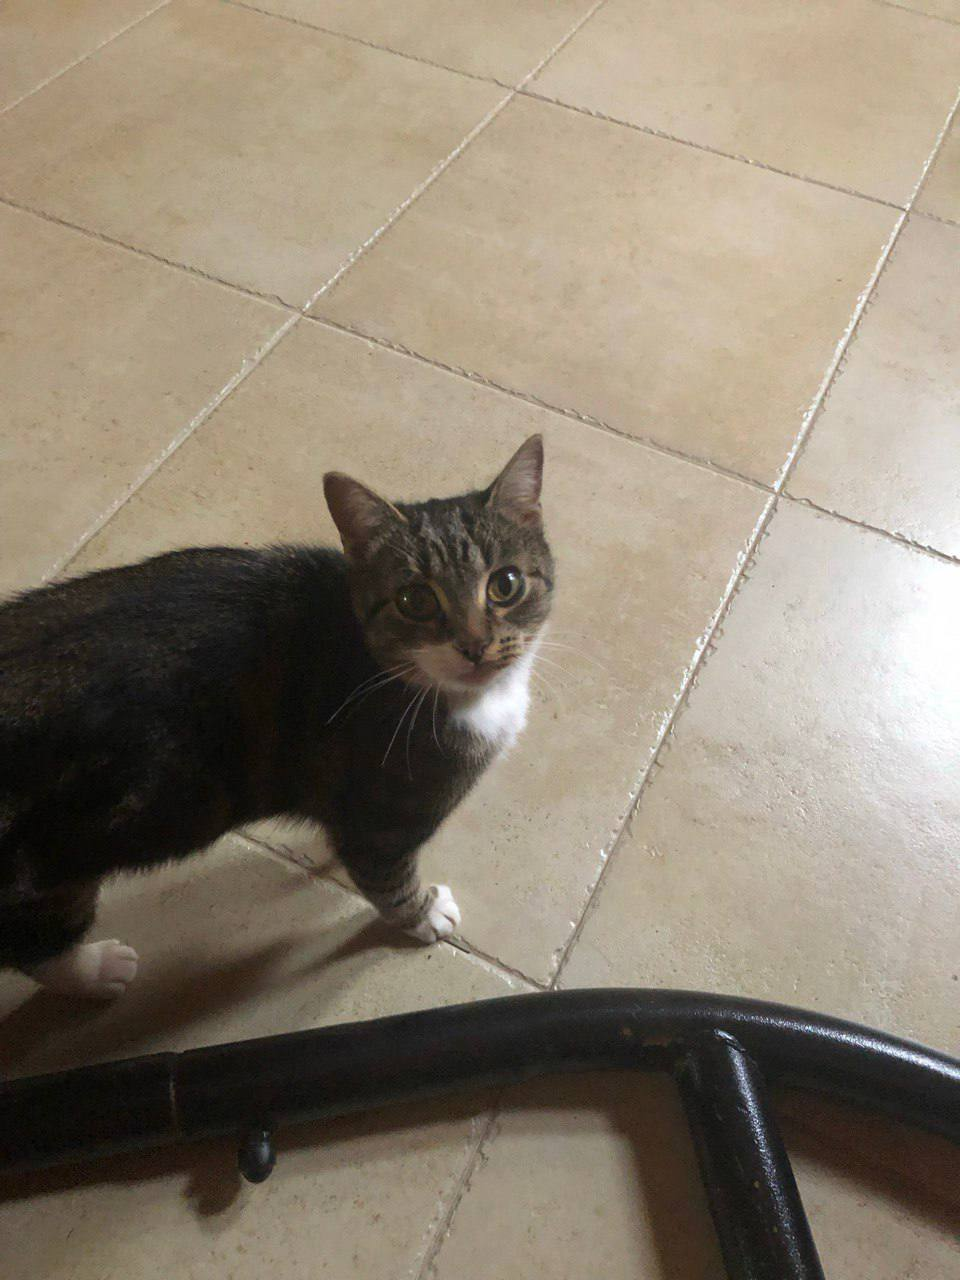